# Plant Disease Classification Pipeline

This notebook demonstrates the end-to-end process of loading data, training a model, and making predictions using the `src` modules.

In [2]:
import os
import sys
import tensorflow as tf
sys.path.append(os.path.abspath('..'))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Import custom modules
from src.model import create_compiled_model, train_model, save_model
from src.preprocessing import load_and_preprocess_single_image
from src.prediction import predict

## 1. Data Processing
We use `ImageDataGenerator` for data augmentation and loading.

In [4]:
DATA_DIR = '../data/train'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")

Found 1059 images belonging to 3 classes.
Found 263 images belonging to 3 classes.
Classes: ['Healthy', 'Powdery', 'Rust']


## 2. Model Creation & Training
We use MobileNetV2 for transfer learning.

In [5]:
model = create_compiled_model(input_shape=IMG_SIZE + (3,), num_classes=len(class_names))
model.summary()

2025-11-25 14:09:09.246140: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-11-25 14:09:09.247470: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-25 14:09:09.247479: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-25 14:09:09.251418: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-25 14:09:09.252098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
history = train_model(model, train_generator, epochs=5)
# Note: In a real scenario, pass validation_data=validation_generator to fit()

Starting model training...


/Users/gustav/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


2025-11-25 14:09:21.440036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4407 - loss: 1.3782
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7773 - loss: 0.5341
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8766 - loss: 0.3429
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8819 - loss: 0.2977
Epoch 5/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9001 - loss: 0.2787
Training complete.


## 3. Evaluation

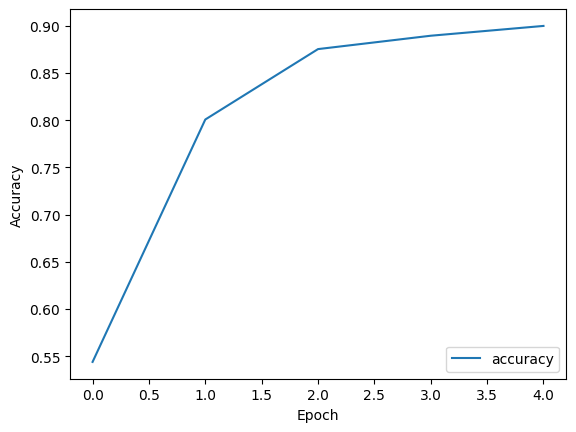

In [7]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## 4. Saving the Model

In [8]:
save_model(model, '../models/plant_disease_model.h5')

Model saved to ../models/plant_disease_model.h5


## 5. Prediction

In [9]:
# Test on a random image from the validation set
# Replace with an actual path
test_image_path = os.path.join(DATA_DIR, class_names[0], os.listdir(os.path.join(DATA_DIR, class_names[0]))[0])

result = predict(model, test_image_path, class_names)
print(f"Prediction: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: {'class': 'Healthy', 'confidence': 0.7871435284614563}
